In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

import dask
import dask.dataframe as dd

ROOT = '/home/ian/data/kaggle/optiver_volatility/'
TRAIN_CSV = os.path.join(ROOT, 'train.csv')

In [2]:
df_train = pd.read_csv(TRAIN_CSV)

In [3]:
df_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [4]:
df_train.describe()

,stock_id,time_id,target
count,428932.000000,428932.000000,428932.000000
mean,62.437944,16038.972721,0.003880
std,37.126450,9365.103706,0.002936
min,0.000000,5.000000,0.000105
25%,30.000000,7854.000000,0.002026
50%,63.000000,15853.000000,0.003048
75%,96.000000,23994.000000,0.004738
max,126.000000,32767.000000,0.070321


In [5]:
df_train.stock_id.nunique()

112

In [6]:
df_train.time_id.nunique()

3830

In [7]:
3830 * 112 # check that stocks * timestamps is almost all the data (but not quite all)

428960

In [8]:
# stocks have 111 or 112 timestamps each|
df_train.time_id.value_counts(dropna=False).sort_values()

23873    111
13735    111
17727    111
6696     111
6925     111
        ... 
32758    112
32763    112
32631    112
32709    112
5213     112
Name: time_id, Length: 3830, dtype: int64

## What can we learn about the continuous target parameter?

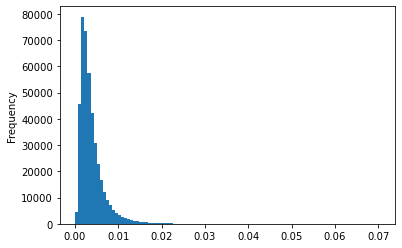

In [9]:
df_train.target.plot(kind="hist", bins=100);
# it'll be a pain to format the y labels

This looks like a Gamma distribution (k==2-9, theta==1?). All positive.

In [10]:
df_train.target.describe(percentiles=[0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
0%            0.000105
5%            0.001176
25%           0.002026
50%           0.003048
75%           0.004738
95%           0.009453
100%          0.070321
max           0.070321
Name: target, dtype: float64

In [11]:
alt.Chart(df_train.sample(5000)).mark_bar().encode(
#x=alt.X('target:Q', bin=True), # default binning
x=alt.X('target:Q', bin=alt.Bin(maxbins=100)),
y='count()', 
)

alt.Chart(...)

In [12]:
import scipy.stats as stats
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(df_train.target.sample(frac=1))#0.99))
# alpha i.e. k == 0.17 or 0.7 or 0.4, beta is 1.5 or 0.005 or 0.009
# WARNING this is really unstable on a subsample, even at 99%!
fit_alpha, fit_loc, fit_beta

(0.16017393883852254, 0.00010526299999999998, 1.984284673859603)

In [13]:
import scipy
# HMMM - THIS LOOKS QUITE WRONG! VALUES TOO LARGE, EARLY VALUE TOO LOW for the fit above
# if instead I hardcode then it looks (vaguely) in the ballpark
fit_alpha = 2
fit_loc = 0.01
fit_beta = 500
random_gamma = scipy.stats.gamma.rvs(fit_alpha, loc=fit_loc, scale=1/fit_beta, size=5000)
df_random_gamma = pd.DataFrame({'target': random_gamma})
alt.Chart(df_random_gamma).mark_bar().encode(
    x=alt.X('target:Q', bin=alt.Bin(maxbins=100)),
    y='count()'
)

alt.Chart(...)

# Book train

For a stock and time_id we have a list of `seconds_in_bucket` of 100s of items.

In [14]:
items_in_folder = os.listdir(os.path.join(ROOT, 'book_train.parquet'))
print(f'There are {len(items_in_folder)} items in the folder and they look like {items_in_folder[:5]}')

There are 112 items in the folder and they look like ['stock_id=59', 'stock_id=58', 'stock_id=23', 'stock_id=17', 'stock_id=109']


In [15]:
df_book_train_stock_0 = pd.read_parquet(os.path.join(ROOT, 'book_train.parquet/stock_id=0'))

In [16]:
df_book_train_stock_0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [17]:
df_book_train_stock_0.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
count,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000,917553.000000
mean,15980.056908,293.692015,0.999904,1.000137,0.999864,1.000177,113.717102,100.825350,86.770241,83.203067
std,9381.778917,173.596440,0.003668,0.003696,0.003702,0.003743,108.657209,109.063892,90.602588,94.968388
min,5.000000,0.000000,0.938241,0.944337,0.937213,0.944456,1.000000,1.000000,1.000000,1.000000
25%,7759.000000,142.000000,0.998368,0.999223,0.998184,0.999390,22.000000,14.000000,18.000000,14.000000
50%,15772.000000,292.000000,0.999632,1.000331,0.999472,1.000496,100.000000,93.000000,100.000000,90.000000
75%,23834.000000,444.000000,1.000753,1.001560,1.000587,1.001745,157.000000,117.000000,102.000000,102.000000
max,32767.000000,599.000000,1.045641,1.056892,1.043756,1.057676,3221.000000,16608.000000,4391.000000,16608.000000


In [18]:
df_book_train_stock_0.query('time_id==5')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3


In [19]:
df_book_train_stock_98 = pd.read_parquet(os.path.join(ROOT, 'book_train.parquet/stock_id=98'))

In [20]:
df_book_train_stock_98.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000257,1.001263,1.000235,1.001308,2,1,4,1
1,5,1,1.000235,1.001263,1.000212,1.001308,4,1,2,1
2,5,4,1.000235,1.001263,1.000212,1.001308,4,1,2,5
3,5,5,1.000235,1.001263,1.000212,1.001308,4,1,2,12
4,5,6,1.000235,1.001263,1.000212,1.001308,4,1,2,3


In [21]:
df_book_train_stock_98.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
count,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000,905795.000000
mean,16010.265356,293.448323,0.999934,1.000159,0.999889,1.000196,116.728145,85.488035,81.129777,66.753292
std,9363.696022,173.897629,0.003392,0.003438,0.003450,0.003503,124.206204,95.147750,107.703764,96.254298
min,5.000000,0.000000,0.948431,0.955833,0.948245,0.955870,1.000000,1.000000,1.000000,1.000000
25%,7837.000000,142.000000,0.998370,0.999310,0.998175,0.999471,18.000000,7.000000,6.000000,4.000000
50%,15883.000000,291.000000,0.999603,1.000407,0.999442,1.000563,100.000000,90.000000,78.000000,41.000000
75%,23892.000000,444.000000,1.000722,1.001658,1.000559,1.001856,160.000000,104.000000,100.000000,100.000000
max,32767.000000,599.000000,1.046545,1.051670,1.046362,1.055001,9497.000000,4300.000000,9597.000000,6300.000000


In [22]:
df_book_train_stock_98.query('time_id==5')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000257,1.001263,1.000235,1.001308,2,1,4,1
1,5,1,1.000235,1.001263,1.000212,1.001308,4,1,2,1
2,5,4,1.000235,1.001263,1.000212,1.001308,4,1,2,5
3,5,5,1.000235,1.001263,1.000212,1.001308,4,1,2,12
4,5,6,1.000235,1.001263,1.000212,1.001308,4,1,2,3
...,...,...,...,...,...,...,...,...,...,...
256,5,590,0.998715,0.999832,0.998580,1.000145,1,6,7,1
257,5,591,0.998715,0.999810,0.998580,0.999832,12,100,7,6
258,5,592,0.998715,0.999273,0.998580,0.999609,11,3,7,1
259,5,593,0.998580,0.999273,0.997820,0.999609,7,4,1,1


In [23]:
from dask.distributed import Client
if 'client' not in dir():
    client = Client(processes=True, n_workers=8, threads_per_worker=1, memory_limit='4GB')
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/ian/workspace/personal_projects/kaggle/optiver_volatility/notebooks/dask-worker-space/worker-1f97js_n', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/ian/workspace/personal_projects/kaggle/optiver_volatility/notebooks/dask-worker-space/worker-bluf0psy', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:43015,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:43811,Total threads: 1
Dashboard: http://127.0.0.1:39859/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:35029,


In [24]:
ddf = dd.read_parquet(os.path.join(ROOT, 'book_train.parquet'))
dask.compute(ddf.shape) # 167M x 11

((167253289, 11),)

# Relationship between taret and bid/ask prices?

In [25]:
STOCK_ID = 1
df_train_stock_X = df_train.query('stock_id==@STOCK_ID')
df_train_stock_X = df_train_stock_X.set_index('time_id').drop(columns=['stock_id'])
df_train_stock_X.head()

,target
time_id,
5,0.006340
11,0.002099
16,0.002456
31,0.002807
62,0.004312


In [26]:
df_train_stock_X.shape

(3830, 1)

In [27]:
df_book_train_stock_X = pd.read_parquet(os.path.join(ROOT, f'book_train.parquet/stock_id={STOCK_ID}'))
#df_book_train_stock_X = df_train.query("stock_id==@STOCK_ID")
df_book_train_stock_X.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25


In [28]:
df_train_stock_X.shape, df_book_train_stock_X.shape

((3830, 1), (1507532, 10))

Observations:

* stock id 0 target vs variance of
  * bid_price1/2  - small positive relationship
  * ask_price1/2 - small positive relationship
  * bid_size1/2 - triangular relationship (ie. pos for small values, negative for larger - maybe?)
  * ask_size1/2 - as for bid size
* stock id 1 - same checks by eye, looks similar

In [29]:
# get a field like bid price, calc variance
col = 'bid_price1'
col = 'ask_price2'
#col = 'bid_size2'
#col = 'ask_size2'
ser_var_on_field = df_book_train_stock_X.groupby('time_id')[col].var()
new_col = col + "_var"
ser_var_on_field.name = new_col
ser_var_on_field

time_id
5        1.367994e-06
11       8.441465e-08
16       6.860287e-07
31       3.293527e-07
62       1.660082e-07
             ...     
32751    6.353813e-08
32753    4.015275e-05
32758    3.060450e-07
32763    2.949488e-06
32767    2.159860e-07
Name: ask_price2_var, Length: 3830, dtype: float32

In [30]:
df_train_stock_X_merge = df_train_stock_X.merge(ser_var_on_field, left_index=True, right_index=True)
assert df_train_stock_X_merge.shape[0] == ser_var_on_field.shape[0]
df_train_stock_X_merge

,target,ask_price2_var
time_id,,
5,0.006340,1.367994e-06
11,0.002099,8.441465e-08
16,0.002456,6.860287e-07
31,0.002807,3.293527e-07
62,0.004312,1.660082e-07
...,...,...
32751,0.003741,6.353813e-08
32753,0.012414,4.015275e-05
32758,0.002868,3.060450e-07


In [31]:
alt.Chart(df_train_stock_X_merge).mark_point().encode(x=new_col, y='target')

alt.Chart(...)

In [32]:
#alt.Chart(df_train_stock_X_merge.query(f'{col}_var < 0.00004')).mark_point().encode(x=new_col, y='target')